<a href="https://colab.research.google.com/github/smerinobluewin/hello-world/blob/master/brown_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[]
[1000000.  993528.  989050. ... 1259503. 1262018. 1262569.]


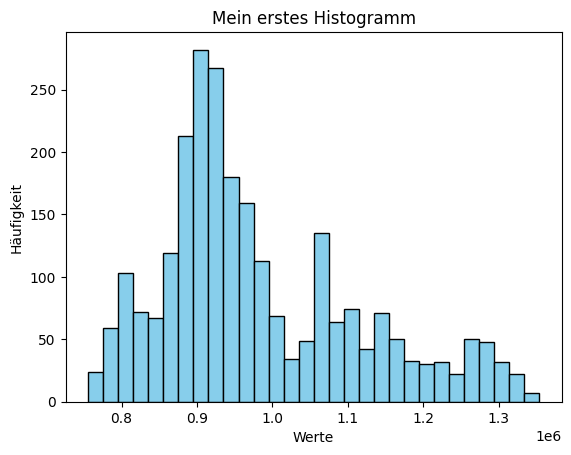

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

mu=0.05
sigma=2*mu
S1=1000000
C=100000
N=30*252
dt=1/252
St=S1
# St=np.array([S1], dtype=np.float32)
for number in range(0,N+1):
  eps=random.normalvariate(mu=0,sigma=1)
  S=S1+S1*(mu*dt+sigma*eps*np.sqrt(dt)) - C*dt
  St=np.column_stack((St,S))
  S1=S

St=np.round(St,0)
print(St[1:10])
print(St[-1])

data=St.flatten()

plt.hist(data, bins=30, color='skyblue', edgecolor='black')
plt.title("Mein erstes Histogramm")
plt.xlabel("Werte")
plt.ylabel("Häufigkeit")
plt.show()


